In [311]:
import os
import numpy as np
import pandas as pd

import skimage.io as skio
import skimage.transform as skit
import skimage.morphology as skim
from sklearn.base import clone

import pulse2percept.implants as p2pi
import argus_shapes

%matplotlib inline
import matplotlib.pyplot as plt

In [52]:
img_argus1 = skio.imread('/home/mbeyeler/Dropbox/UW/argus_i.jpg')
img_argus2 = skio.imread('/home/mbeyeler/Dropbox/UW/argus_ii.jpg')

In [53]:
px_argus1 = np.array([
    [  93.12857037,  162.32202802],
    [ 138.00952276,  163.7029804 ],
    [ 178.74761799,  163.01250421],
    [ 227.77142752,  161.63155183],
    [  93.12857037,  208.58393279],
    [ 143.53333228,  207.8934566 ],
    [ 182.89047514,  207.2029804 ],
    [ 227.77142752,  206.51250421],
    [  93.12857037,  251.3934566 ],
    [ 137.31904657,  251.3934566 ],
    [ 180.81904657,  251.3934566 ],
    [ 227.08095133,  251.3934566 ],
    [  93.81904657,  296.27440898],
    [ 140.08095133,  296.27440898],
    [ 182.89047514,  297.65536136],
    [ 227.08095133,  297.65536136]
])

px_argus2 = np.array([
    [ 296.94026284,  140.58506571], [ 328.48148148,  138.4823178 ],
    [ 365.27956989,  140.58506571], [ 397.87216249,  139.53369176],
    [ 429.41338112,  138.4823178 ], [ 463.05734767,  140.58506571],
    [ 495.64994026,  139.53369176], [ 528.24253286,  139.53369176],
    [ 560.83512545,  139.53369176], [ 593.42771804,  138.4823178 ],
    [ 296.94026284,  173.1776583 ], [ 329.53285544,  174.22903226],
    [ 363.17682198,  173.1776583 ], [ 396.82078853,  173.1776583 ],
    [ 430.46475508,  173.1776583 ], [ 463.05734767,  174.22903226],
    [ 494.59856631,  173.1776583 ], [ 529.29390681,  174.22903226],
    [ 559.78375149,  175.28040621], [ 593.42771804,  173.1776583 ],
    [ 296.94026284,  206.82162485], [ 329.53285544,  206.82162485],
    [ 363.17682198,  205.7702509 ], [ 395.76941458,  205.7702509 ],
    [ 429.41338112,  205.7702509 ], [ 463.05734767,  208.92437276],
    [ 496.70131422,  207.87299881], [ 529.29390681,  209.97574671],
    [ 559.78375149,  208.92437276], [ 592.37634409,  206.82162485],
    [ 296.94026284,  240.4655914 ], [ 330.58422939,  240.4655914 ],
    [ 363.17682198,  240.4655914 ], [ 396.82078853,  240.4655914 ],
    [ 430.46475508,  240.4655914 ], [ 460.95459976,  240.4655914 ],
    [ 494.59856631,  242.56833931], [ 528.24253286,  239.41421744],
    [ 559.78375149,  240.4655914 ], [ 593.42771804,  241.51696535],
    [ 297.9916368 ,  274.10955795], [ 328.48148148,  273.05818399],
    [ 361.07407407,  274.10955795], [ 395.76941458,  273.05818399],
    [ 428.36200717,  274.10955795], [ 463.05734767,  273.05818399],
    [ 494.59856631,  275.1609319 ], [ 526.13978495,  274.10955795],
    [ 560.83512545,  274.10955795], [ 591.32497013,  274.10955795],
    [ 295.88888889,  306.70215054], [ 329.53285544,  305.65077658],
    [ 363.17682198,  305.65077658], [ 393.66666667,  307.75352449],
    [ 427.31063321,  307.75352449], [ 459.90322581,  305.65077658],
    [ 492.4958184 ,  308.80489845], [ 527.1911589 ,  307.75352449],
    [ 559.78375149,  307.75352449], [ 590.27359618,  306.70215054]
])

In [15]:
datafolder = os.environ['ARGUS_SHAPES_DATA']
subjectdata = argus_shapes.load_subjects(os.path.join(datafolder, 'subjects.csv'))

In [16]:
subjects = subjectdata.index.sort_values()

In [96]:
X, y = argus_shapes.load_data(os.path.join(datafolder, 'drawings_single.csv'))
Xy = pd.concat((X, y.drop(columns='electrode')), axis=1)

In [97]:
Xmu, ymu = argus_shapes.calc_mean_images(X, y, thresh=False, max_area=np.inf)
Xymu = pd.concat((Xmu, ymu.drop(columns='electrode')), axis=1)

In [98]:
assert Xy.electrode.unique().sort() == Xymu.electrode.unique().sort()

In [307]:
best_worst = pd.DataFrame([
    {'subject': 'S1', 'best': 'D2', 'worst': 'D1'},
    {'subject': 'S2', 'best': 'C10', 'worst': 'F2'},
    {'subject': 'S3', 'best': 'E1', 'worst': 'C10'},
    {'subject': 'S4', 'best': 'F9', 'worst': 'C4'}
]).set_index('subject')
best_worst

,best,worst
subject,,
S1,D2,D1
S2,C10,F2
S3,E1,C10
S4,F9,C4


In [328]:
def get_img_array(subject, Xymu, subjectdata):
    implant_type = subjectdata.loc[subject, 'implant_type']
    is_argus2 = isinstance(implant_type(), p2pi.ArgusII)
    if is_argus2:
        return img_argus2
    else:
        return img_argus1

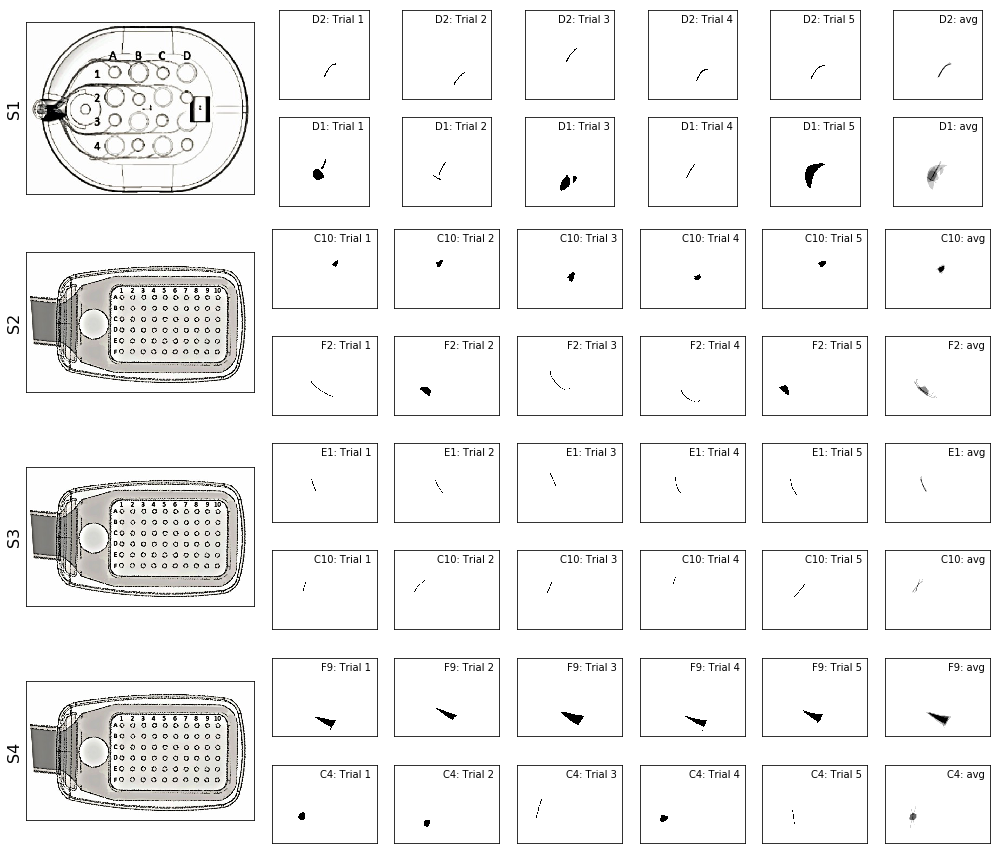

In [335]:
fig = plt.figure(figsize=(14, 3 * len(subjects)))

for s, subject in enumerate(subjects):
    ax1 = plt.subplot2grid((2 * len(subjects), 8), (s * 2, 0), rowspan=2, colspan=2)
    img_array = get_img_array(subject, Xymu, subjectdata)
    ax1.imshow(img_array)
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_ylabel(subject, fontsize=16)
    for r, bw in enumerate(['best', 'worst']):
        electrode = best_worst.loc[subject, bw]
        idx_drawings = np.logical_and(Xy.subject == subject, Xy.electrode == electrode)
        for c, (_, drawing) in enumerate(Xy[idx_drawings].iterrows()):
            ax2 = plt.subplot2grid((2 * len(subjects), 8), (2 * s + r, c + 2))
            img_th = argus_shapes.imgproc.get_thresholded_image(drawing['image'])
            ax2.imshow(1 - img_th, cmap='gray')
            ax2.set_xticks([])
            ax2.set_yticks([])
            ax2.text(0.95 * img_th.shape[1], 0.05 * img_th.shape[0], 
                     '%s: Trial %d' % (electrode, c + 1), fontsize=10, ha='right', va='top')
        ax3 = plt.subplot2grid((2 * len(subjects), 8), (2 * s + r, 7))
        idx_drawings = np.logical_and(Xymu.subject == subject, Xymu.electrode == electrode)
        img_avg = ymu.loc[idx_drawings, 'image'].values[0]
        ax3.imshow(1 - img_avg, cmap='gray')
        ax3.text(0.95 * img_avg.shape[1], 0.05 * img_avg.shape[0],
                 '%s: avg' % electrode, fontsize=10, ha='right', va='top')
        ax3.set_xticks([])
        ax3.set_yticks([])
fig.tight_layout()
fig.savefig('fig2-phosphene-shape.png')

In [132]:
X, y = argus_shapes.calc_mean_images(X, y, thresh=True)
np.sort(X.electrode.unique())

array(['A1', 'A10', 'A2', 'A4', 'A5', 'A6', 'A7', 'A8', 'B1', 'B2', 'B3',
       'B4', 'B7', 'B9', 'C1', 'C10', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7',
       'C8', 'D1', 'D10', 'D2', 'D3', 'D4', 'D5', 'D7', 'E1', 'E10', 'E3',
       'E4', 'E5', 'E7', 'E9', 'F10', 'F4', 'F6', 'F7', 'F8', 'F9'], dtype=object)

In [6]:
argus_shapes.exclude_bistables(X, y)[0].electrode.unique()

AttributeError: module 'argus_shapes' has no attribute 'exclude_bistables'

In [ ]:
plt.imshow(y[y.electrode == 'B1'].image.values[0])

In [ ]:
subjects = argus_shapes.load_subjects(os.path.join(os.environ['SHAPE_DATA'], 'subjects.csv'))
subjects

In [ ]:
data = argus_shapes.load_data(os.path.join(os.environ['SHAPE_DATA'], 'drawings_single.csv'))
data.groupby(['subject_id', 'electrode']).count()

In [ ]:
meow

In [ ]:
subject = '51-009'
model = 'C'

picklefolder = os.path.join('..', '..', 'results', 'shape5fit')
datafolder = os.path.join(os.environ['SECOND_SIGHT_DATA'], 'shape')

In [ ]:
if 'implant_x' not in best_params:
    if hasattr(reg, 'implant_x'):
        best_params['implant_x'] = reg.implant_x
        best_params['implant_y'] = reg.implant_y
        best_params['implant_rot'] = reg.implant_rot
    else:
        best_params['implant_x'] = 0
        best_params['implant_y'] = 0
        best_params['implant_rot'] = 0

In [ ]:
if isinstance(reg.implant_type(), p2p.implants.ArgusI):
    argus = p2p.implants.ArgusI(x_center=best_params['implant_x'],
                                y_center=best_params['implant_y'],
                                rot=best_params['implant_rot'])
    px_argus = px_argus1
    img_argus = img_argus1
else:
    argus = p2p.implants.ArgusII(x_center=best_params['implant_x'],
                                 y_center=best_params['implant_y'],
                                 rot=best_params['implant_rot'])
    px_argus = px_argus2
    img_argus = img_argus2

In [ ]:
x_range = reg.xrange
y_range = reg.yrange
out_shape = (np.diff(y_range)[0] * 10, np.diff(x_range)[0] * 10)
out_shape

In [ ]:
pts_in = []
pts_dva = []
pts_out = []
for xy, e in zip(px_argus, argus):
    pts_in.append(xy)
    
    dva = p2p.retina.ret2dva([e.x_center, e.y_center])
    pts_dva.append(dva)
    
    xout = (dva[0] - x_range[0]) / (x_range[1] - x_range[0]) * (out_shape[1] - 1)
    yout = (dva[1] - y_range[0]) / (y_range[1] - y_range[0]) * (out_shape[0] - 1)
    pts_out.append([xout, yout])

In [ ]:
argus2dva = skit.estimate_transform('similarity', np.array(pts_in), np.array(pts_dva))
dva2out = skit.estimate_transform('similarity', np.array(pts_dva), np.array(pts_out))
argus2out = skit.estimate_transform('similarity', np.array(pts_in), np.array(pts_out))

In [ ]:
X, y = argus_shapes.load_data(datafolder, subject=subject, amplitude=amplitude)
X, y = argus_shapes.exclude_bistables(X, y)
X, y = argus_shapes.calc_mean_images(X, y, thresh=False)

In [ ]:
def get_avg_image(X, y, electrode, amp, align_center, scale=1):
    idx = (X['electrode'] == electrode) & (X['amplitude'] == amp)
    avg_img = y[idx]['image'].values
    
    if len(avg_img) == 0:
        return None
    
    avg_img = avg_img[0] / avg_img[0].max()
    
    avg_img = argus_shapes.imgproc.center_phosphene(avg_img)
    
    avg_img = argus_shapes.imgproc.scale_phosphene(avg_img, scale)

    transl = [align_center[0] - avg_img.shape[1] // 2,
              align_center[1] - avg_img.shape[0] // 2]
    trafo = skit.EuclideanTransform(translation=transl)
    avg_img = skit.warp(avg_img, trafo.inverse)
    return avg_img

In [ ]:
electrodes = np.unique(X.groupby(['electrode', 'amplitude']).electrode.all())
amps = np.unique(X['amplitude'])
assert len(amps) == 1
assert np.isclose(amps, amplitude)
print(electrodes)
print(amplitude)

In [ ]:
if not hasattr(reg, 'n_ax_segments'):
    reg.set_params(xystep=0.1, n_ax_segments=500)
reg._curr_map = {}
!rm axons.pickle
reg.fit(X)

In [ ]:
def get_pred_image(Xrow, model, align_center, scale=1):
    pred_img = model._predicts_image(Xrow)
    if pred_img is None:
        return None
    
    pred_img = argus_shapes.imgproc.get_thresholded_image(pred_img, thresh=model.img_thresh,
                                                        out_shape=Xrow[1]['img_shape'])
    pred_img = argus_shapes.imgproc.center_phosphene(pred_img)

    pred_img = argus_shapes.imgproc.scale_phosphene(pred_img, scale)

    transl = [align_center[0] - pred_img.shape[1] // 2,
              align_center[1] - pred_img.shape[0] // 2]
    trafo = skit.EuclideanTransform(translation=transl)
    pred_img = skit.warp(pred_img, trafo.inverse)
    return pred_img

In [ ]:
fovea = dva2out([0, 0])[0]
scale = 0.6

fig, axes = plt.subplots(ncols=2, figsize=(15, 6))
fig.tight_layout()

ax = axes[0]
ax.set_facecolor('white')
for el in electrodes:
    ename = '%s%d' % (el[0], int(el[1:]))
    e_pos = p2p.retina.ret2dva((argus[ename].x_center, argus[ename].y_center))
    align_center = dva2out(e_pos)[0]
    avg = get_avg_image(X, y, el, amplitude, align_center, scale=scale)
#     ax.imshow(1 - avg, cmap='gray')
    if avg is None:
        print('%s: avg is None' % ename)
        continue
    ax.imshow(1 - np.ma.masked_where(avg < 0.5, avg), cmap='gray')
    ax.set_title('%s: %.2fx threshold' % (subject, amplitude))
ax.imshow(skit.warp(img_argus, argus2out.inverse, cval=1.0, output_shape=out_shape), alpha=0.3)
ax.scatter(fovea[0], fovea[1], s=100, marker='s', c='w', edgecolors='k')

ax = axes[1]
ax.set_facecolor('white')
for Xrow in X.iterrows():
    el = Xrow[1]['electrode']
    ename = '%s%d' % (el[0], int(el[1:]))
    e_pos = p2p.retina.ret2dva((argus[ename].x_center, argus[ename].y_center))
    align_center = dva2out(e_pos)[0]
    pred_img = get_pred_image(Xrow, reg, align_center, scale=scale)
    if pred_img is None:
        print('%s: pred is None' % ename)
        continue
    ax.imshow(1 - np.ma.masked_where(pred_img < 0.5, pred_img), cmap='gray')
    ax.set_title('%s: %.2fx threshold' % (subject, amplitude))
ax.imshow(skit.warp(img_argus, argus2out.inverse, cval=1.0, output_shape=out_shape), alpha=0.3)
ax.scatter(fovea[0], fovea[1], s=100, marker='s', c='w', edgecolors='k')

fig.savefig('shape-%s-%s.png' % (subject, model))